# Comparing NCAR LES with sPALM

This notebook compares the NCAR LES and a customized version of [PALM](https://palm.muk.uni-hannover.de/trac) in two cases described in [McWilliams et al., 1997](https://doi.org/10.1017/S0022112096004375):
- A shear turbulence (ST) case
- A Langmuir turbulence (LT) case


Benchmark with 32 MPI processes and [nx, ny, nz] = [128, 128, 120]:

- sPALM ([3051fa2](https://github.com/qingli411/palm_les_lanl/tree/3051fa2efe6017a8893833235a672936815d67a8))

| Case          | Time step | Run time (s) | Time per step (s) |
|---------------|-----------|--------------|-------------------|
| NCAR LES (ST) | 14400     | 2752.84      | 0.191             |
| NCAR LES (LT) | 14400     | 2761.91      | 0.192             |
| sPALM (ST)    | 16169     | 2237.39      | 0.138             |
| sPALM (LT)    | 13819     | 1971.35      | 0.143             |


In [1]:
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.environ['HOME']+'/work/lesview')
from lesview import *

In [2]:
# load data
casenames = ['MSM97-ST', 'MSM97-LT']
ncarles_pfl = {}
palm_pfl = {}
ncarles_data_1d_pfl = 'his.mp.vis.000001.014401.nc'
palm_data_1d_pfl = 'DATA_1D_PR_NETCDF'
lesdata_dir = os.environ['HOME']+'/work/lesdata'
for casename in casenames:
    ncarles_dir = os.environ['HOME']+'/scratch/benchmark/NCARLES/badger/ncarles/data/ncarles_'+casename
    palm_dir = os.environ['HOME']+'/scratch/benchmark/sPALM/3051fa2/badger/RUN_lanl_intel_cpu_mpi_PALM_ocean_'+casename
    ncarles_pfl[casename] = NCARLESDataProfile(filepath=ncarles_dir+'/'+ncarles_data_1d_pfl)
    palm_pfl[casename] = PALMDataProfile(filepath=palm_dir+'/'+palm_data_1d_pfl)

In [3]:
# one inertial period (17 hours)
startdate = '2000-01-02T01:00:00'
enddate = '2000-01-02T18:00:00'

In [4]:
ncarles_var = {'T':       'txym',
               'u':       'uxym',
               'v':       'vxym',
               'w2':      'wps',
               'diss':    't_dsle',
               'tke':     'englez',
               'tke_sgs': 'engsbz',
               'uw':      'uwle',
               'uw_sgs':  'uwsb',
               'vw':      'vwle',
               'vw_sgs':  'vwsb',
               'wt':      'wtle',
               'wt_sgs':  'wtsb'}
palm_var    = {'T':       'pt',
               'u':       'u',
               'v':       'v',
               'w2':      'w*2',
               'diss':    'diss',
               'tke':     'e*', 
               'tke_sgs': 'e', 
               'uw':      'w*u*',
               'uw_sgs':  'w"u"',
               'vw':      'w*v*',
               'vw_sgs':  'w"v"',
               'wt':      'w*pt*',
               'wt_sgs':  'w"pt"'}
colors = {'MSM97-ST': 'k', 'MSM97-LT': 'r'}
models = ['NCAR LES', 'PALM']

In [5]:
def cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60, cmap='viridis', var_sgs=None):
    if cmap == 'viridis':
        label_color = 'w'
    else:
        label_color = 'k'
    fig1, axarr = plt.subplots(2, 2, sharex='col', sharey='row')
    fig1.set_size_inches([10, 6])
    if var_sgs is None:
        for i, casename in enumerate(casenames):
            ncarles_pfl[casename].dataset.data_vars[ncarles_var[var]].sel(
                time=slice(startdate, enddate)).plot(ax=axarr[0, i], levels=levels,
                                                     add_colorbar=False, cmap=cmap)
            im = palm_pfl[casename].dataset.data_vars[palm_var[var]].sel(
                time=slice(startdate, enddate)).plot(ax=axarr[1, i], levels=levels,
                                                     add_colorbar=False, cmap=cmap)
    else:
        for i, casename in enumerate(casenames):
            (ncarles_pfl[casename].dataset.data_vars[ncarles_var[var]] +
             ncarles_pfl[casename].dataset.data_vars[ncarles_var[var_sgs]]).sel(
                time=slice(startdate, enddate)).plot(ax=axarr[0, i], levels=levels,
                                                     add_colorbar=False, cmap=cmap)
            im = (palm_pfl[casename].dataset.data_vars[palm_var[var]] +
                  palm_pfl[casename].dataset.data_vars[palm_var[var_sgs]]).sel(
                time=slice(startdate, enddate)).plot(ax=axarr[1, i], levels=levels,
                                                     add_colorbar=False, cmap=cmap)
    for i, casename in enumerate(casenames):
        axarr[0,i].set_title(casename)
        for j in np.arange(2):
            axarr[j,i].set_ylim([depth, 0])
            axarr[j,i].set_xlabel('')
            axarr[j,0].set_ylabel('depth (m)')
            axarr[j,1].set_ylabel('')
            axarr[j,i].text(0.05, 0.15, models[j], transform=axarr[j,i].transAxes,
                fontsize=10, color=label_color, va='top')

    plt.subplots_adjust(left=0.1, right=0.86, bottom=0.1, top=0.92, wspace=0.1, hspace=0.1)

    # colorbar
    cax = plt.axes([0.8, 0.25, 0.1, 0.5])
    cax.set_visible(False)
    cb = plt.colorbar(im, ax=cax)
    cb.formatter.set_powerlimits((-2, 3))
    cb.set_label(var+' ('+units+')')



    fig2 = plt.figure(figsize=[6,4])
    if var_sgs is None:
        for casename in casenames:
            ds0 = ncarles_pfl[casename].dataset.data_vars[ncarles_var[var]]
            ds0.sel(time=slice(startdate, enddate)).mean(dim='time').plot(
                y=ds0.dims[0], color=colors[casename], linestyle='-', label=models[0]+' '+casename)
            ds1 = palm_pfl[casename].dataset.data_vars[palm_var[var]]
            ds1.sel(time=slice(startdate, enddate)).mean(dim='time').plot(
                y=ds1.dims[0], color=colors[casename], linestyle='--', label=models[1]+' '+casename)
    else:
        for casename in casenames:
            ds0 = (ncarles_pfl[casename].dataset.data_vars[ncarles_var[var]] +
                ncarles_pfl[casename].dataset.data_vars[ncarles_var[var_sgs]])
            ds0.sel(time=slice(startdate, enddate)).mean(dim='time').plot(
                y=ds0.dims[0], color=colors[casename], linestyle='-', label=models[0]+' '+casename)
            ds1 = (palm_pfl[casename].dataset.data_vars[palm_var[var]] +
                palm_pfl[casename].dataset.data_vars[palm_var[var_sgs]])
            ds1.sel(time=slice(startdate, enddate)).mean(dim='time').plot(
                y=ds1.dims[0], color=colors[casename], linestyle='--', label=models[1]+' '+casename)
    vmin = np.min(levels)
    vmax = np.max(levels)
    plt.ylim([depth, 0])
    plt.xlim([vmin, vmax])
    plt.xlabel(var+' ('+units+')')
    plt.ylabel('Depth (m)')
    plt.legend()

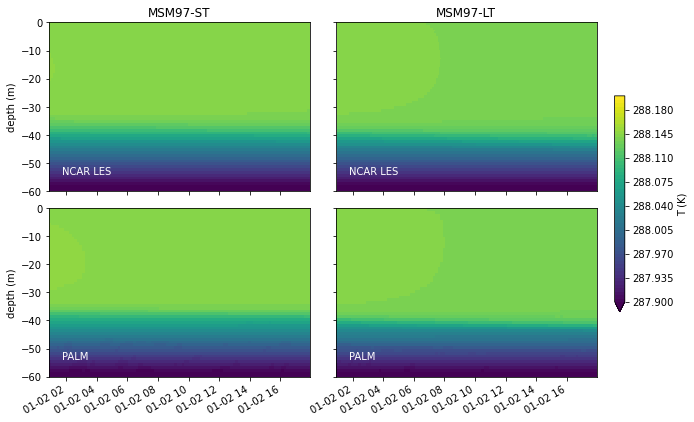

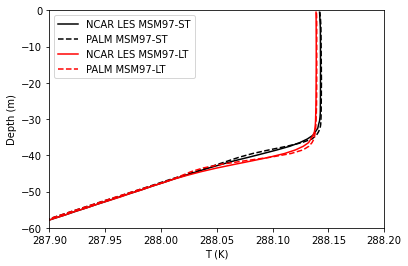

In [6]:
var = 'T'
units = 'K'
levels = np.linspace(287.9, 288.2, 61)
cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60, cmap='viridis')

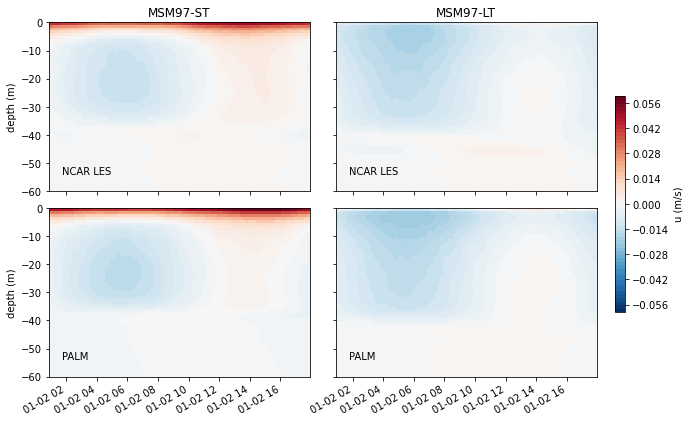

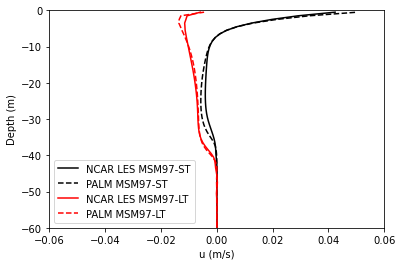

In [7]:
var = 'u'
units = 'm/s'
levels = np.linspace(-0.06, 0.06, 61)
cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60, cmap='RdBu_r')

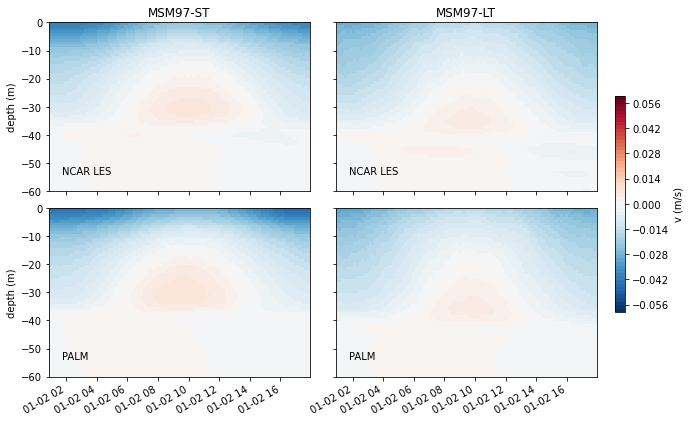

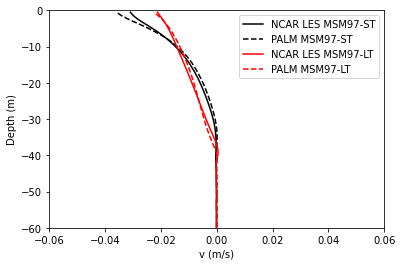

In [8]:
var = 'v'
units = 'm/s'
levels = np.linspace(-0.06, 0.06, 61)
cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60, cmap='RdBu_r')

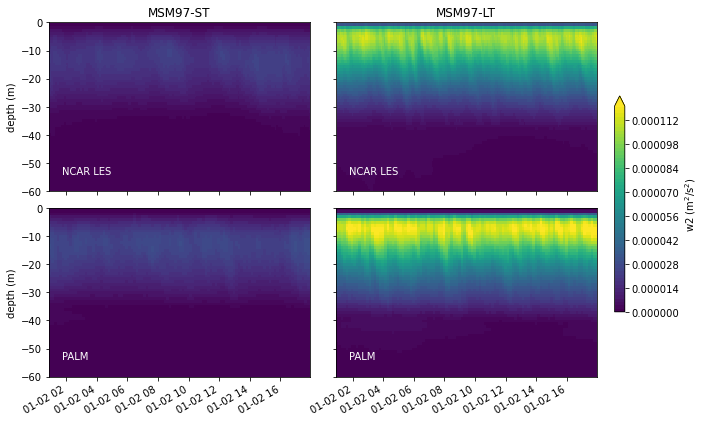

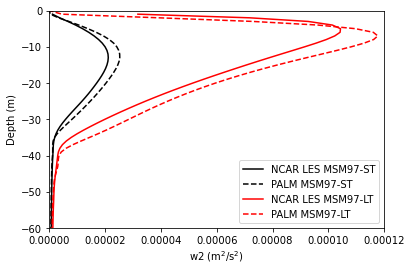

In [9]:
var = 'w2'
units = 'm$^2$/s$^2$'
levels = np.linspace(0, 1.2e-4, 61)
cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60)

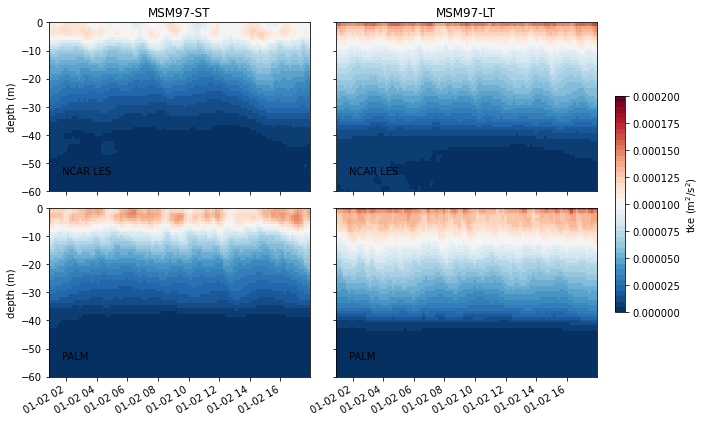

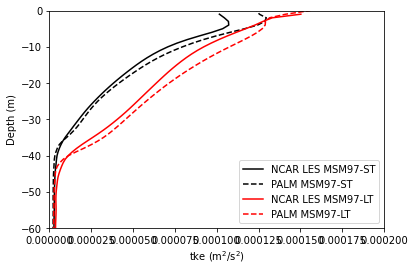

In [10]:
var = 'tke'
units = 'm$^2$/s$^2$'
levels = np.linspace(0, 2e-4, 41)
cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60, cmap='RdBu_r')

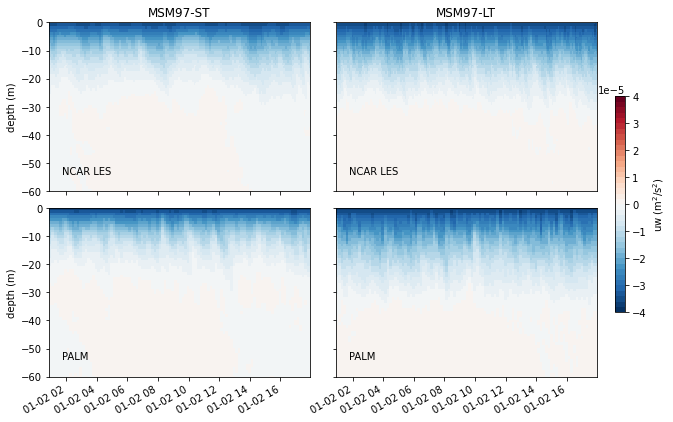

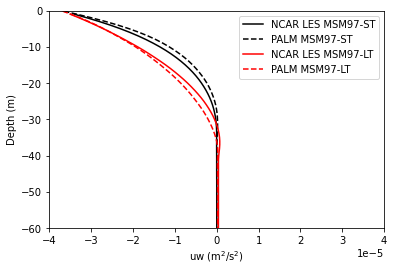

In [11]:
var = 'uw'
var_sgs = 'uw_sgs'
units = 'm$^2$/s$^2$'
levels = np.linspace(-4e-5, 4e-5, 41)
cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60, cmap='RdBu_r', var_sgs=var_sgs)

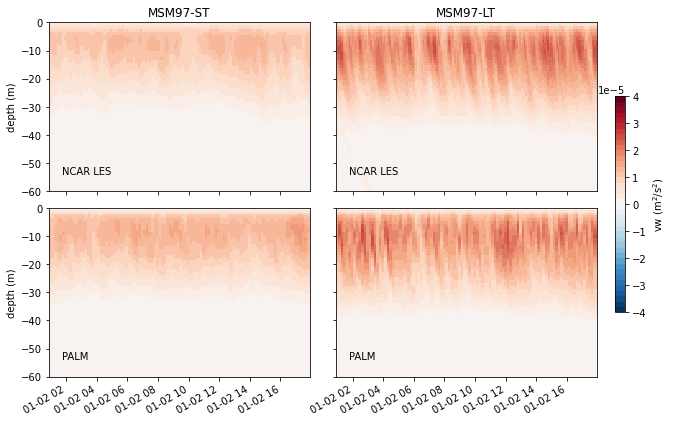

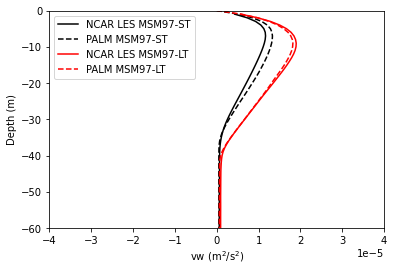

In [12]:
var = 'vw'
var_sgs = 'vw_sgs'
units = 'm$^2$/s$^2$'
levels = np.linspace(-4e-5, 4e-5, 41)
cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60, cmap='RdBu_r', var_sgs=var_sgs)

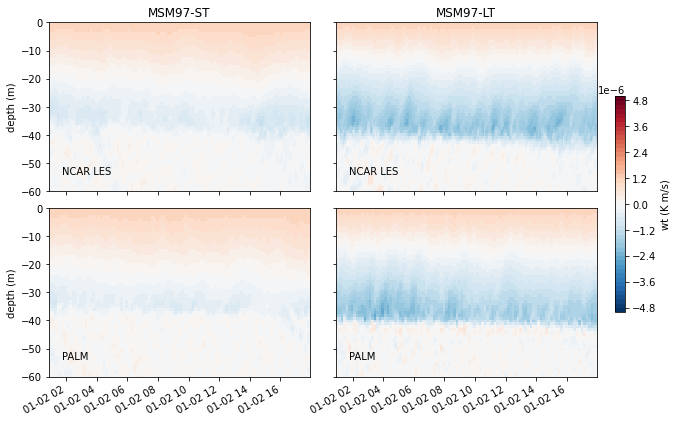

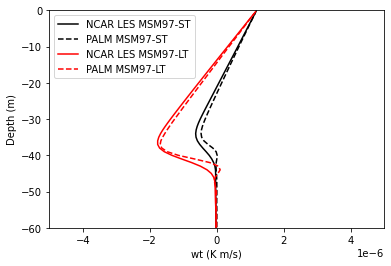

In [13]:
var = 'wt'
var_sgs = 'wt_sgs'
units = 'K m/s'
levels = np.linspace(-5e-6, 5e-6, 51)
cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60, cmap='RdBu_r', var_sgs=var_sgs)

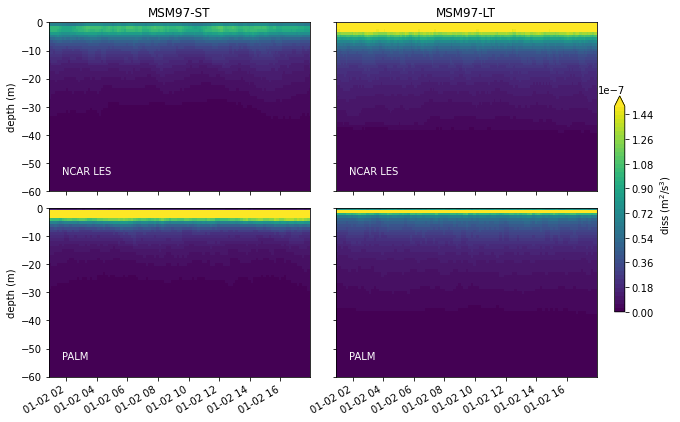

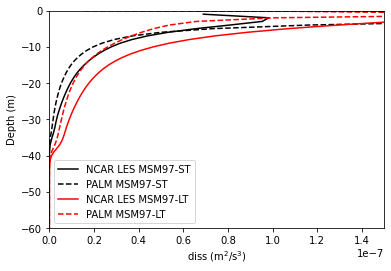

In [14]:
var = 'diss'
units = 'm$^2$/s$^3$'
levels = np.linspace(0, 1.5e-7, 51)
cmp_var(ncarles_pfl, palm_pfl, var, units, levels, depth=-60)

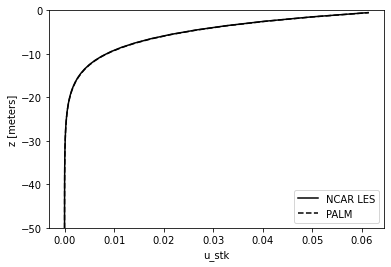

In [15]:
casename = 'MSM97-LT'
ds0 = ncarles_pfl[casename].dataset.data_vars['stokes']
ds0.sel(time=slice(startdate, enddate)).mean(dim='time').plot(y=ds0.dims[0], color='k',
                                                              linestyle='-', label='NCAR LES')
ds1 = palm_pfl[casename].dataset.data_vars['u_stk']
ds1.sel(time=slice(startdate, enddate)).mean(dim='time').plot(y=ds1.dims[0], color='k',
                                                              linestyle='--', label='PALM')
plt.ylim([-50,0])
plt.legend()